In [12]:
# Initialize Otter
import otter
grader = otter.Notebook("lab08.ipynb")

# Lab 8: Multiple Linear Regression and Feature Engineering

In this lab, we will work through the process of:
1. Implementing a linear model 
1. Defining loss functions
1. Feature engineering
1. Minimizing loss functions using numeric methods and analytical methods 

This lab will continue using the toy `tips` calculation dataset used in Labs 6 and 7.

**This assignment should be completed and submitted by Thursday March 18th, 2021 at 11:59pm PST**

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** at the top of this notebook.

### Lab Walkthrough Video

In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

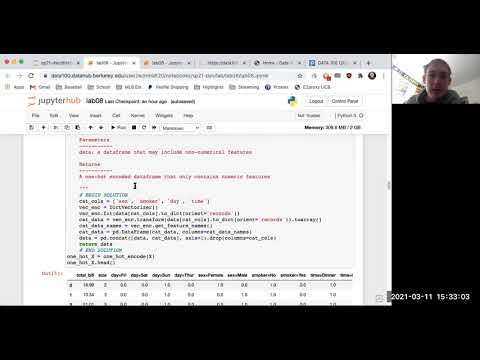

In [13]:
from IPython.display import YouTubeVideo
YouTubeVideo("xOUXFmnm4YU")

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")
%matplotlib inline

# Loading the Tips Dataset

To begin, let's load the tips dataset from the `seaborn` library.  This dataset contains records of tips, total bill, and information about the person who paid the bill. This is the same dataset used in Lab 6, so it should look familiar! We looked at predicting tips based on one feature (total bill) in Lab 7.

In [15]:
data = sns.load_dataset("tips")

print("Number of Records:", len(data))
data.head()

Number of Records: 244


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


## Question 1: Defining the Model and Feature Engineering

In Lab 6 we used the constant model. Now let's make a more complicated model that utilizes other features in our dataset. Let our prediction for tip be a combination of the following features:

$$ \text{Tip} = \theta_1 \cdot \text{total}\_\text{bill} + \theta_2 \cdot \text{sex} + \theta_3 \cdot \text{smoker} + \theta_4 \cdot \text{day} + \theta_5 \cdot \text{time} + \theta_6 \cdot \text{size} $$

Notice that some of these features are not numbers! But our linear model will need to predict a numerical value. Let's start by converting some of these non-numerical values into numerical values. Below we split the tips and the features.

In [16]:
tips = data['tip']
X = data.drop(columns='tip')

### Question 1a: Feature Engineering

First, let's convert our features to numerical values. A straightforward approach is to map some of these non-numerical features into numerical ones. 

For example, we can treat the day as a value from 1-7. However, one of the disadvantages in directly translating to a numeric value is that we unintentionally assign certain features disproportionate weight. Consider assigning Sunday to the numeric value of 7, and Monday to the numeric value of 1. In our linear model, Sunday will have 7 times the influence of Monday, which can lower the accuracy of our model.

Instead, let's use one-hot encoding to better represent these features! 

As discussed in lecture, one-hot encoding will produce a binary vector indicating the non-numeric feature. 

In the `tips` dataset for example, we encode Sunday as the vector `[0 0 0 1]` because our dataset only contains bills from Thursday through Sunday. This assigns a more even weight across each category in non-numeric features. Complete the code below to one-hot encode our dataset. This dataframe holds our "featurized" data, which is also often denoted by $\phi$.

<!--
BEGIN QUESTION
name: q1a
-->

In [18]:
def one_hot_encode(data):
    """
    Return the one-hot encoded dataframe of our input data.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features
    
    """
    columns = ['sex', 'smoker', 'day', 'time']
    for column in columns:
        values = data[column].unique()
        for value in values:
            data[column + '=' + value] = (data[column] == value).astype(int)
            
        data = data.drop(column,axis=1)
    return data
            
one_hot_X = one_hot_encode(X)
one_hot_X.head()

,total_bill,size,sex=Female,sex=Male,smoker=No,smoker=Yes,day=Sun,day=Sat,day=Thur,day=Fri,time=Dinner,time=Lunch
0,16.99,2,1,0,1,0,1,0,0,0,1,0
1,10.34,3,0,1,1,0,1,0,0,0,1,0
2,21.01,3,0,1,1,0,1,0,0,0,1,0
3,23.68,2,0,1,1,0,1,0,0,0,1,0
4,24.59,4,1,0,1,0,1,0,0,0,1,0


In [19]:
grader.check("q1a")

q1a passed!

### Question 1b: Defining the Model

Now that all of our data is numeric, we can begin to define our model function. Notice that after one-hot encoding our data, we now have 12 features instead of 6. Therefore, our linear model now looks like:

$$ \text{Tip} = \theta_1 \cdot \text{size} + \theta_2 \cdot \text{total}\_\text{bill} + \theta_3 \cdot \text{day}\_\text{Thur} + \theta_4 \cdot \text{day}\_\text{Fri} + ... + \theta_{11} \cdot \text{time}\_\text{Lunch} + \theta_{12} \cdot \text{time}\_\text{Dinner} $$

We can represent the linear combination above as a matrix-vector product. Implement the `linear_model` function to evaluate this product.

**Hint**: You can use [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html), [pd.DataFrame.dot](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dot.html), or the `@` operator to multiply matrices/vectors. However, while the `@` operator can be used to multiply `numpy` arrays, it generally will not work between two `pandas` objects, so keep that in mind when computing matrix-vector products!

<!--
BEGIN QUESTION
name: q1b
-->

In [20]:
def linear_model(thetas, X):
    """
    Return the linear combination of thetas and features as defined above.
    
    Parameters
    -----------
    thetas: a 1D vector representing the parameters of our model ([theta1, theta2, ...])
    X: a 2D dataframe of numeric features (may also be a 2D numpy array)
    
    Returns
    -----------
    A 1D vector representing the linear combination of thetas and features as defined above.
    """
    
    return np.dot(X,thetas)
    
    

In [21]:
grader.check("q1b")

q1b passed!

## Question 2: Fitting the Model using Numeric Methods

Recall in Lab 6 we defined multiple loss functions and found THE optimal theta using the `scipy.minimize` function. Adapt the loss functions and optimization code from Lab 6 (provided below) to work with our new linear model.

<!--
BEGIN QUESTION
name: q2
-->

In [24]:
from scipy.optimize import minimize

def l1(y, y_hat):
    return np.abs(y - y_hat)

def l2(y, y_hat):
    return (y - y_hat)**2

def minimize_average_loss(loss_function, model, X, y):
    """
    Minimize the average loss calculated from using different theta vectors, and 
    estimate the optimal theta for the model.
    
    Parameters
    -----------
    loss_function: either the squared or absolute loss functions defined above
    model: the model (as defined in Question 1b)
    X: a 2D dataframe (or numpy array) of numeric features (one-hot encoded)
    y: a 1D vector of tip amounts
    
    Returns
    -----------
    The estimate for the optimal theta vector that minimizes our loss
    """
    
    ## Notes on the following function call which you need to finish:
    # 
    # 0. The first '...' should be replaced with the average loss evaluated on 
    #       the data X, y using the model and appropriate loss function.
    # 1. x0 is the initial value for THETA.  Yes, this is confusing
    #       but optimization people like x to be the thing they are 
    #       optimizing. Replace the second '...' with an initial value for theta,
    #       and remember that theta is now a vector. DO NOT hard-code the length of x0;
    #       it should depend on the number of features in X. Look into np.random.
    # 2. Your answer will be very similar to your answer to question 2 from lab 7.
    ...
    return minimize(lambda theta: np.mean(loss_function(y,model(theta,X))), x0= np.ones(X.shape[1]))['x']
    # Notice above that we extract the 'x' entry in the dictionary returned by `minimize`. 
    # This entry corresponds to the optimal theta estimated by the function.

minimize_average_loss(l2, linear_model, one_hot_X, tips)

array([0.09448685, 0.175993  , 0.07369388, 0.04125372, 0.10067815,
       0.01426991, 0.58055708, 0.48457955, 0.44377461, 0.60603645,
       0.02340726, 0.0915401 ])

In [25]:
grader.check("q2")

q2 passed!

## Question 3: Fitting the Model using Analytic Methods

Let's also fit our model analytically for the L2 loss function. Recall from lecture that with a linear model, we are solving the following optimization problem for least squares:

$$\min_{\theta} ||\Bbb{X}\theta - \Bbb{y}||^2$$

We showed in [Lecture 13](https://docs.google.com/presentation/d/15olJS1Yuk22spzrNx4It6-eLm8gkZM4pFKKOWhKXBUI/edit#slide=id.p) that the optimal $\hat{\theta}$ when $X^TX$ is invertible is given by the equation: $(X^TX)^{-1}X^TY$

### Question 3a: Analytic Solution Using Explicit Inverses

For this problem, implement the analytic solution above using `np.linalg.inv` to compute the inverse of $X^TX$.

Reminder: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()`

In [27]:
def get_analytical_sol(X, y):
    """
    Computes the analytical solution to our least squares problem
    
    Parameters
    -----------
    X: a 2D dataframe (or numpy array) of numeric features (one-hot encoded)
    y: a 1D vector of tip amounts
    
    Returns
    -----------
    The estimate for theta computed using the equation mentioned above
    """
    
    return np.linalg.inv(X.T @ X) @ X.T @ y

Now, run the cell below to find the analytical solution for the `tips` dataset. Depending on the machine that you run your code on, you should either see an error or end up with thetas that are nonsensical (magnitudes greater than 10^15). This is not good!

In [28]:
analytical_thetas = get_analytical_sol(one_hot_X, tips)
analytical_thetas

0     5.646638e-01
1     8.543545e-01
2     6.869448e+14
3     6.869448e+14
4    -1.109680e+15
5    -1.109680e+15
6     4.227352e+14
7     4.227352e+14
8     4.227352e+14
9     4.227352e+14
10   -5.784375e+00
11   -3.905859e+00
dtype: float64

In the cell below, explain why we got the error above when trying to calculate the analytical solution for our one-hot encoded `tips` dataset.

<!--
BEGIN QUESTION
name: q3a
-->

X^T X is not invertible, because X is not full rank.
X is not full rank due to linear dependency.

### Question 3b: Fixing our One-Hot Encoding

Now, let's fix our one-hot encoding approach so we don't get the error we did earlier. Complete the code below to one-hot-encode our dataset such that `one_hot_X_revised` has no redundant features.

<!--
BEGIN QUESTION
name: q3b
-->

In [29]:
def one_hot_encode_revised(data):
    """
    Return the one-hot encoded dataframe of our input data, removing redundancies.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features without any redundancies.
    
    """
    columns = ['sex', 'smoker', 'day', 'time']
    for column in columns:
        values = data[column].unique()
        for value in values[:-1]:
            data[column + '=' + value] = (data[column] == value).astype(int)
        data = data.drop(column,axis=1)
    return data

one_hot_X_revised = one_hot_encode_revised(X)
revised_analytical_thetas = get_analytical_sol(one_hot_X_revised, tips)
print("Our analytical loss is: ", l2(linear_model(revised_analytical_thetas, one_hot_X_revised), tips).mean())
print("Our numerical loss is: ", l2(linear_model(minimize_average_loss(l2, linear_model, one_hot_X_revised, tips), one_hot_X_revised), tips).mean())

Our analytical loss is:  1.010353561225785
Our numerical loss is:  1.0103535612260908


In [30]:
grader.check("q3b")

q3b passed!

### Question 3c: Analyzing our new One-Hot Encoding

Why did removing redundancies in our one-hot encoding fix the problem we had in 3a?
<!--
BEGIN QUESTION
name: q3c
-->

getting rid of one column from each "set" got rid of linear dependency

---

Note: An alternate approach is to use `np.linalg.solve` instead of `np.linalg.inv`. For the example above, even with the redundant features, `np.linalg.solve` will work well. Though in general, it's best to drop redundant features anyway.

In case you want to learn more, here is a relevant Stack Overflow post: https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [31]:
grader.check_all()

q1a passed!

q1b passed!

q2 passed!

q3b passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)